#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 12264, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 12264 (delta 18), reused 24 (delta 13), pack-reused 12229
Receiving objects: 100% (12264/12264), 12.01 MiB | 8.94 MiB/s, done.
Resolving deltas: 100% (8488/8488), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 41.5 MB/s 
Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Download Formatted Custom Dataset 

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 46.1 MB/s 
     |████████████████████████████████| 178 kB 67.6 MB/s 
     |████████████████████████████████| 1.1 MB 59.8 MB/s 
     |████████████████████████████████| 67 kB 7.6 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 138 kB 75.2 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.4-py3-none-any.whl size=21356 sha256=f1d1a8eb136d3125e866c2541bd8c3ed56e84c160a05a598d813a72f12078f83
  Stored in directory: /root/.cache/pip/wheels/b7/2c/60/3733c0e323b1d7aec00f852264314bf6c48192c8e1dc92b3ee
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e98719cceee922ffb162b16d5d17beef93566c12602c04981a2863b0951dc0ef
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [ ]:
%cd /content/yolov5
# #after following the link above, recieve python code with these fields filled in
rf = Roboflow(api_key="HqjH96fAj9ywmYrObx62")
project = rf.workspace().project("tcc3")
dataset = project.version(1).download("yolov5")
!pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="HqjH96fAj9ywmYrObx62")
# project = rf.workspace("juliana-prado").project("tcc3")
# dataset = project.version(2).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to tcc3-1 in yolov5pytorch:: 100%|██████████| 1548/1548 [00:01<00:00, 1328.01it/s]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- bulgari
- calvinklein
- cartier
- chanel
- coach
- hermes
- loreal
- poloralphlauren
- prada
- tommyhilfiger
nc: 10
train: tcc3-1/train/images
val: tcc3-1/valid/images


# Define Model Configuration and Architecture

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs 
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 649 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 1113 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='/content/yolov5/tcc3-1/data.yaml', device='', entity=None, epochs=649, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard wi

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.


In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

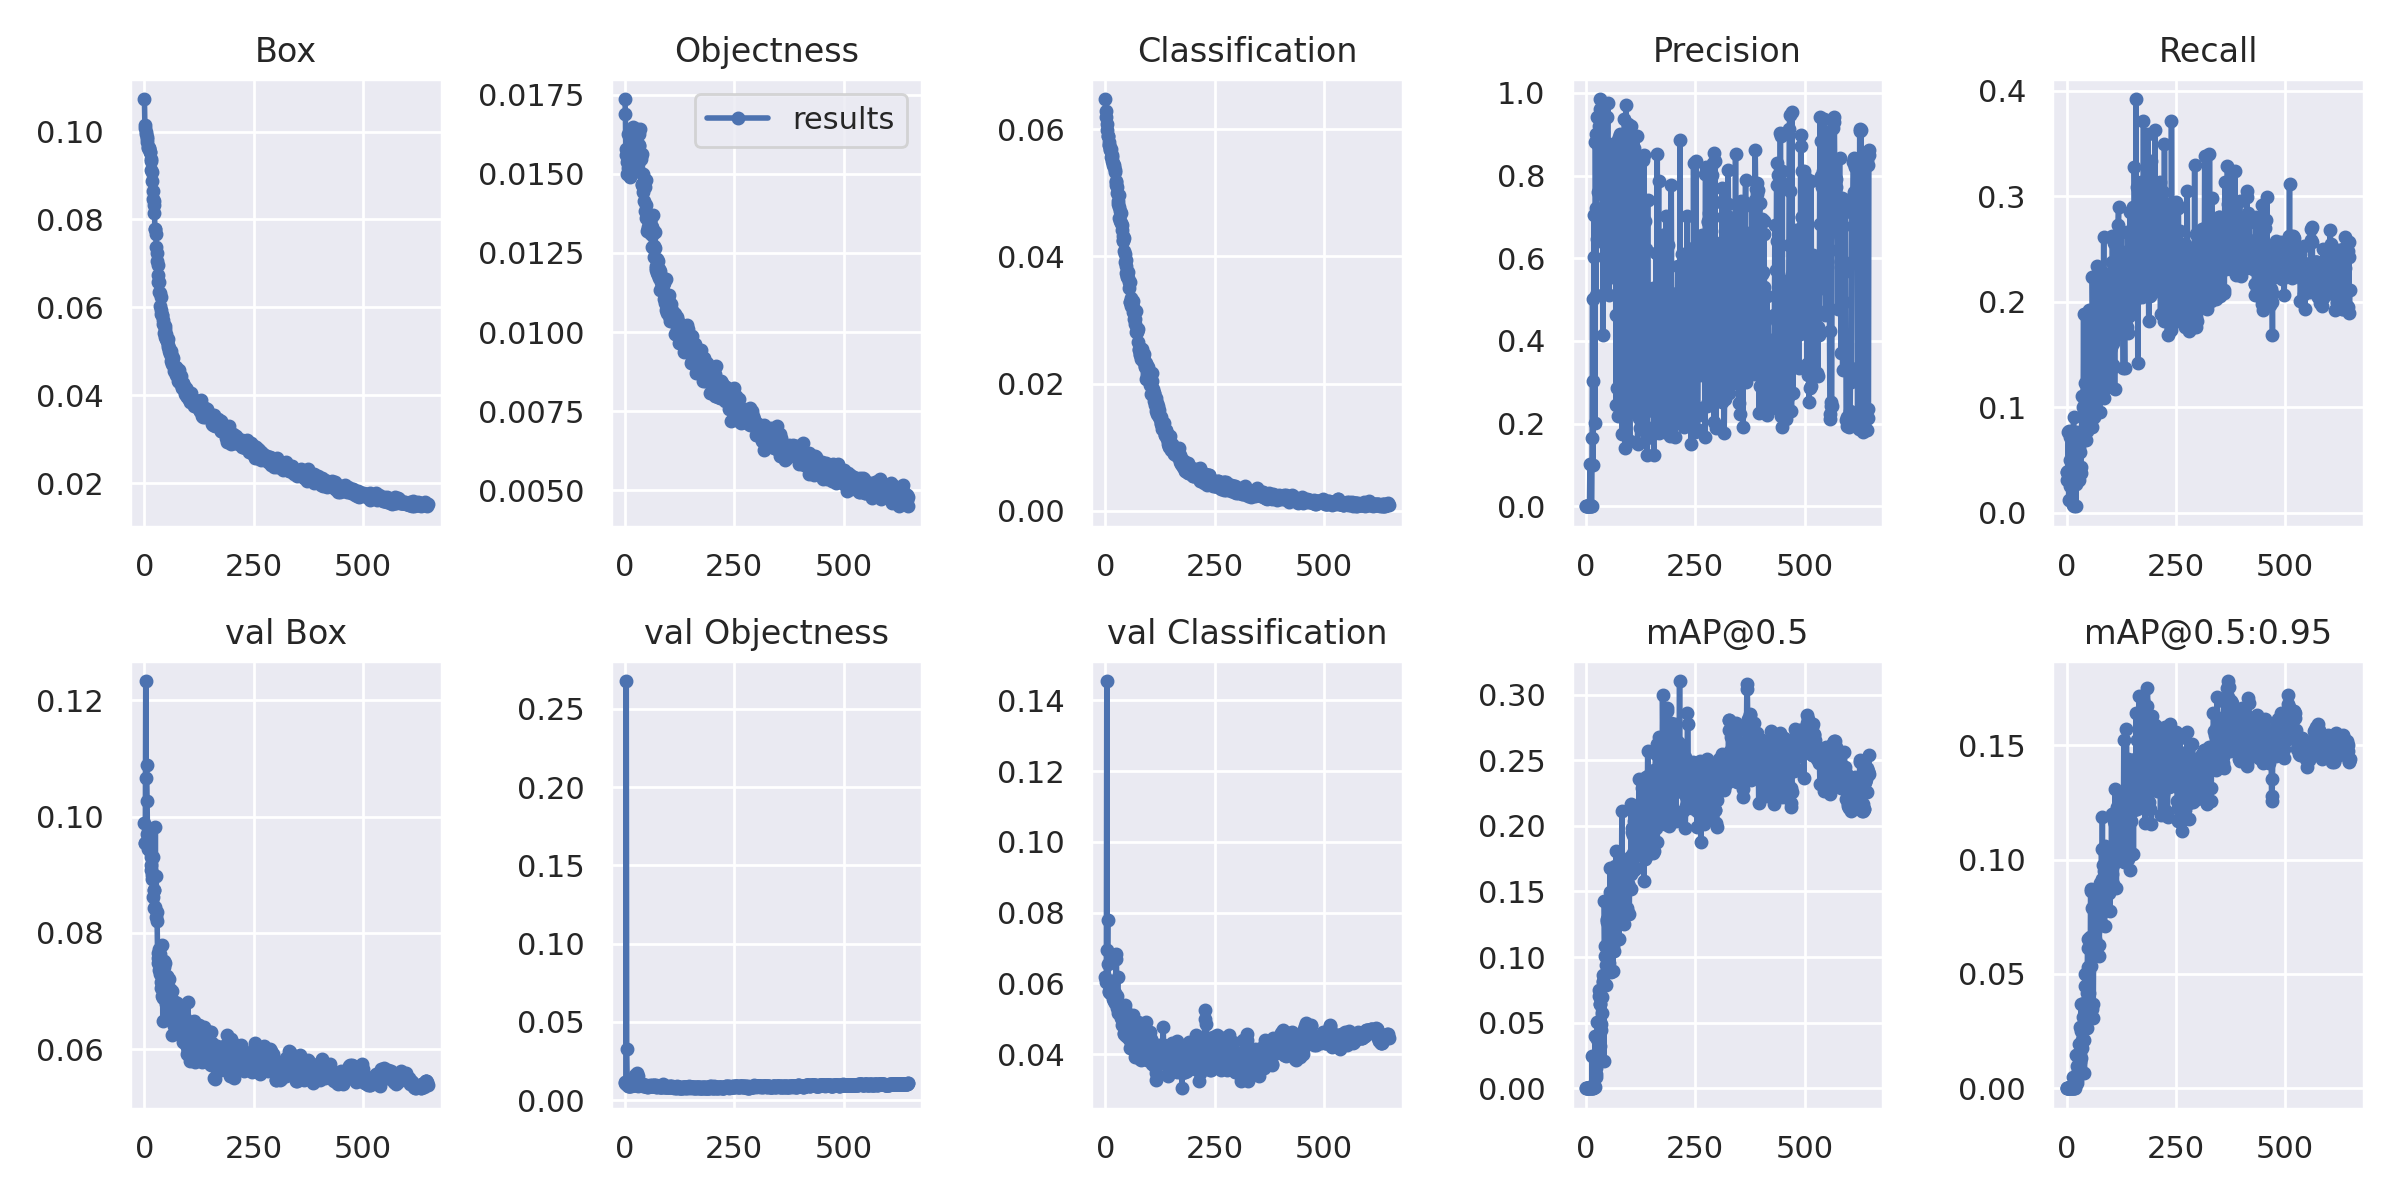

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Visualize]ing Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


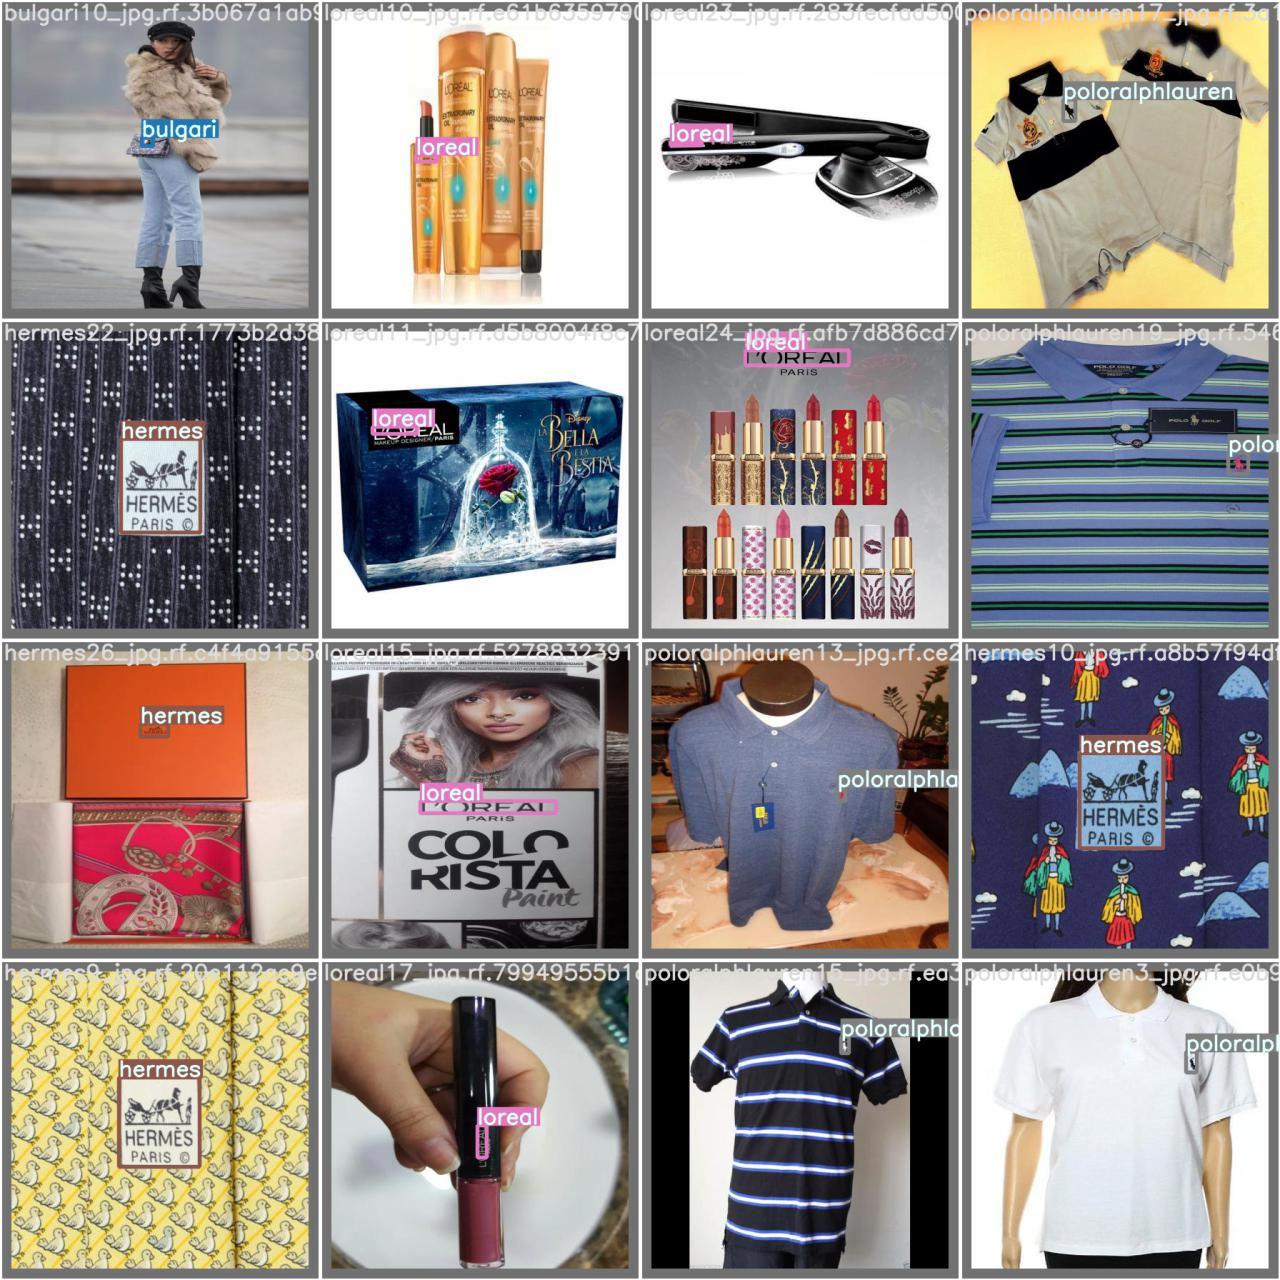

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


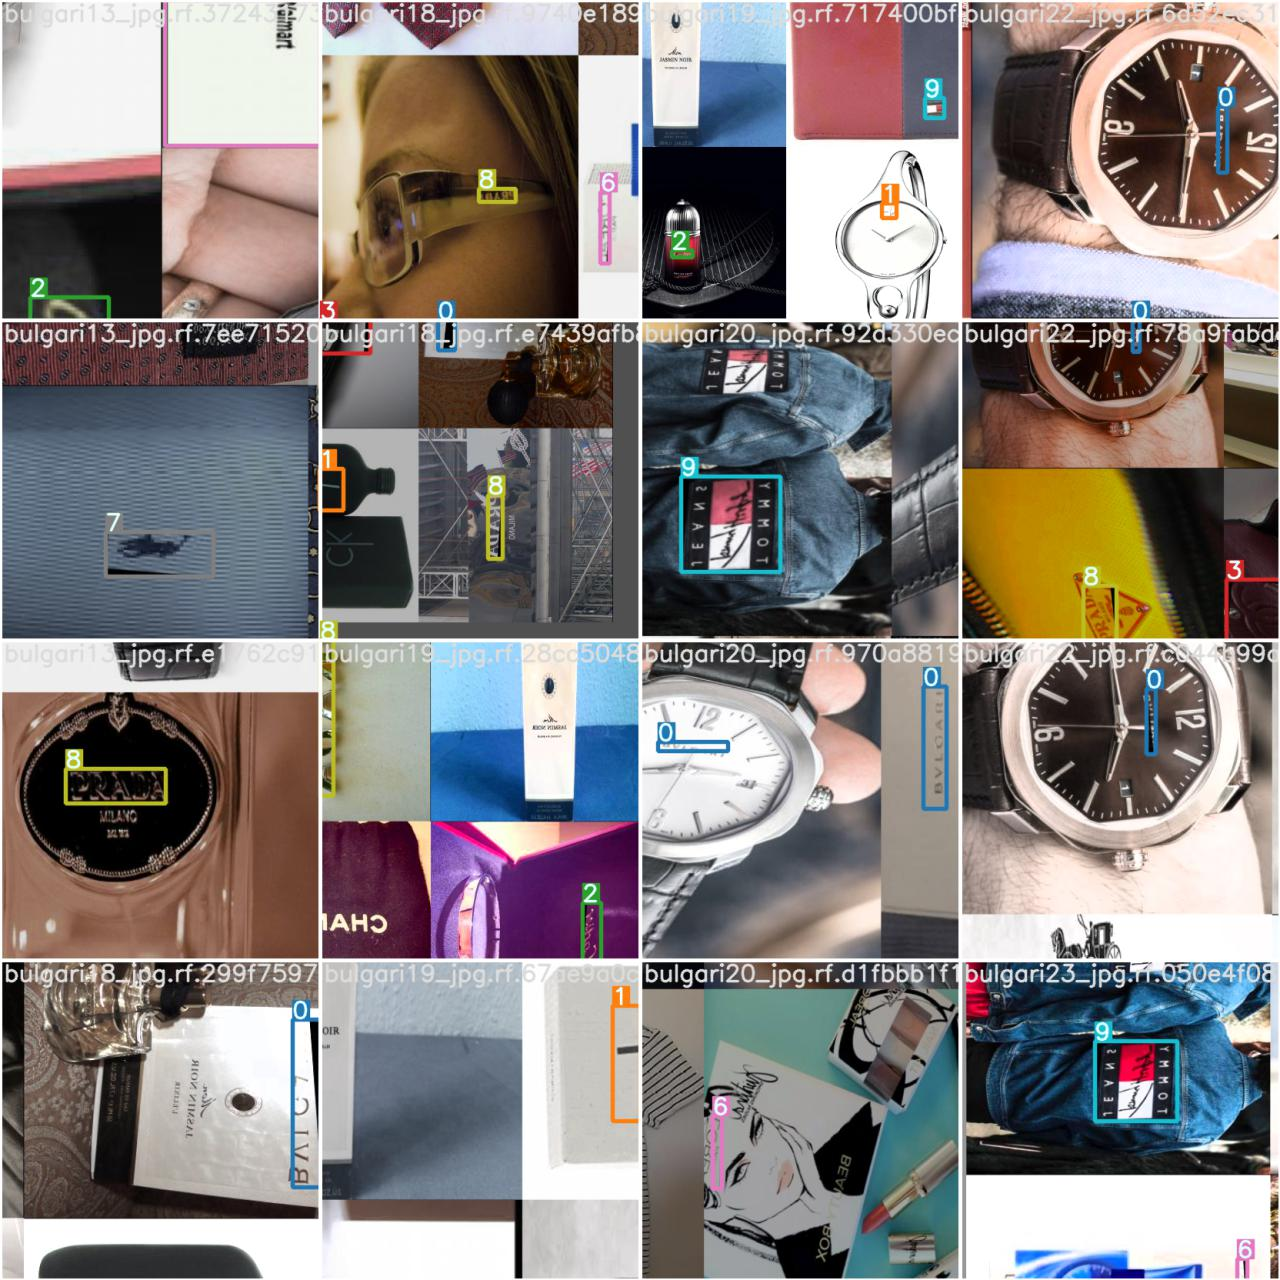

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results2/weights

ls: cannot access 'runs/train/yolov5s_results2/weights': No such file or directory


In [ ]:
import cv2
from google.colab import drive
drive.mount('/content/drive')
video_name = "/content/drive/My Drive/Youtube3.mp4" # or any other extension like .avi etc
vidcap = cv2.VideoCapture(video_name)
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite("/content/sample_data/YouTube2/frame%d.jpg" % count, image)    # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

print('end')

Mounted at /content/drive
end


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.0001 --source /content/sample_data/YouTube/

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.0001, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/sample_data/YouTube/', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7270791 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/917 /content/sample_data/YouTube/frame1000.jpg: 256x416 2 bulgaris, 15 chanels, 9 loreals, 6 poloralphlaurens, 13 pradas, 2 tommyhilfigers, Done. (0.051s)
image 2/917 /content/sample_

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My Drive/